In [3]:

# This script imports necessary libraries for image processing and deep learning using U-Net architecture.
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
framObjTrain = {'img' : [],
           'mask' : []
          }

def LoadData(frameObj=None, imgPath=None, maskPath=None, shape=128):
    """
    Load data from image and mask directories and resize them to the specified shape.

    Args:
        frameObj (dict): Dictionary to store the loaded images and masks.
        imgPath (str): Path to the directory containing the images.
        maskPath (str): Path to the directory containing the masks.
        shape (int): Desired shape for resizing the images and masks.

    Returns:
        dict: Dictionary containing the loaded and resized images and masks.
    """
    imgNames = os.listdir(imgPath)
    maskNames = []

    ## generating mask names
    for mem in imgNames:
        mem = mem.split('_')[0]
        if mem not in maskNames:
            maskNames.append(mem)

    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'

    for i in range(len(imgNames)):
        try:
            img = plt.imread(imgAddr + maskNames[i] + '_sat.jpg')
            mask = plt.imread(maskAddr + maskNames[i] + '_mask.png')

        except:
            continue
        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        frameObj['img'].append(img)
        frameObj['mask'].append(mask[:, :, 0])  # this is because its a binary mask and img is present in channel 0

    return frameObj

In [5]:
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    """
    Creates a convolutional block consisting of two convolutional layers with batch normalization and ReLU activation.
    
    Parameters:
    inputTensor (Tensor): Input tensor to the convolutional block.
    numFilters (int): Number of filters for the convolutional layers.
    kernelSize (int): Size of the kernel for the convolutional layers. Default is 3.
    doBatchNorm (bool): Whether to apply batch normalization. Default is True.
    
    Returns:
    Tensor: Output tensor from the convolutional block.
    """
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

def unetBlock(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    """
    Creates a U-Net model for semantic segmentation.

    Parameters:
    - inputImage: Input image tensor.
    - numFilters: Number of filters in the first convolutional layer (default: 16).
    - droupouts: Dropout rate (default: 0.1).
    - doBatchNorm: Whether to apply batch normalization (default: True).

    Returns:
    - model: U-Net model for semantic segmentation.
    """
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model


In [6]:
"""
This code block initializes the input layer for the U-Net model with a shape of (128, 128, 3).
It then creates a U-Net model using the `unetBlock` function, with a dropout rate of 0.07.
The model is compiled with the Adam optimizer, binary crossentropy loss, and accuracy metric.
"""
inputs = tf.keras.layers.Input((128, 128, 3))
unet = unetBlock(inputs, droupouts= 0.07)
unet.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )


In [7]:
"""
This function is used to train the U-Net model for object detection.
"""
trainPath = 'data/train'
framObjTrain = LoadData( framObjTrain, imgPath = trainPath, 
                        maskPath = trainPath
                         , shape = 128)

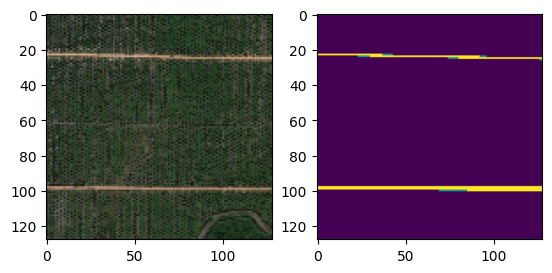

In [8]:
"""
Display the image and mask using subplots.

This function plots the image and mask using subplots. It assumes that the `framObjTrain` variable
contains a dictionary with the 'img' and 'mask' keys, where the values are arrays representing
the image and mask respectively.

"""
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.show()


In [9]:
len(framObjTrain['img'])

6226

In [10]:
"""
Train a U-Net model using the given image and mask data. epochs should be 83
"""
retVal = unet.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 83, verbose = 1)

Epoch 1/83
195/195 ━━━━━━━━━━━━━━━━━━━━ 76s 362ms/step - accuracy: 0.9324 - loss: 0.3012
Epoch 2/83
195/195 ━━━━━━━━━━━━━━━━━━━━ 71s 365ms/step - accuracy: 0.9533 - loss: 0.1737
Epoch 3/83
195/195 ━━━━━━━━━━━━━━━━━━━━ 71s 365ms/step - accuracy: 0.9533 - loss: 0.1458
Epoch 4/83
195/195 ━━━━━━━━━━━━━━━━━━━━ 73s 372ms/step - accuracy: 0.9535 - loss: 0.1321
Epoch 5/83
195/195 ━━━━━━━━━━━━━━━━━━━━ 70s 359ms/step - accuracy: 0.9552 - loss: 0.1224
Epoch 6/83
195/195 ━━━━━━━━━━━━━━━━━━━━ 70s 360ms/step - accuracy: 0.9565 - loss: 0.1157
Epoch 7/83
195/195 ━━━━━━━━━━━━━━━━━━━━ 70s 360ms/step - accuracy: 0.9573 - loss: 0.1118
Epoch 8/83
195/195 ━━━━━━━━━━━━━━━━━━━━ 71s 363ms/step - accuracy: 0.9585 - loss: 0.1070
Epoch 9/83
195/195 ━━━━━━━━━━━━━━━━━━━━ 72s 370ms/step - accuracy: 0.9595 - loss: 0.1028
Epoch 10/83
195/195 ━━━━━━━━━━━━━━━━━━━━ 69s 352ms/step - accuracy: 0.9604 - loss: 0.0998
Epoch 11/83
195/195 ━━━━━━━━━━━━━━━━━━━━ 69s 353ms/step - accuracy: 0.9611 - loss: 0.0974
Epoch 12/83
195/195

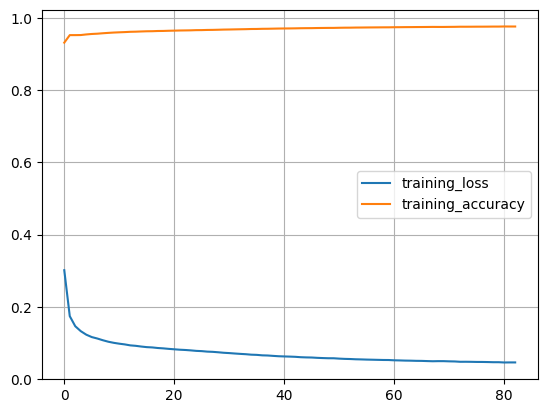

In [11]:
"""
Plots the training loss and accuracy from the `retVal` history.

Parameters:
- retVal (object): The history object containing the training loss and accuracy.

Returns:
None
"""
plt.plot(retVal.history['loss'], label='training_loss')
plt.plot(retVal.history['accuracy'], label='training_accuracy')
plt.legend()
plt.grid(True)

In [12]:
def predict16(valMap, model, shape=128):
    """
    Predicts the output for a batch of 16 images using the given model.

    Args:
        valMap (dict): A dictionary containing the input images and masks.
        model: The trained model used for prediction.
        shape (int): The shape of the images.

    Returns:
        predictions: The predicted output for the batch of images.
        imgProc: The processed input images.
        mask: The ground truth masks.
    """
    img = valMap['img'][0:16]
    mask = valMap['mask'][0:16]
    
    imgProc = img[0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)

    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    """
    Plots the aerial image, predicted routes, and actual routes side by side.

    Args:
        img (numpy.ndarray): The aerial image.
        predMask (numpy.ndarray): The predicted routes.
        groundTruth (numpy.ndarray): The actual routes.
    """
    plt.figure(figsize=(9,9))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Aerial image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Routes')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual Routes')

In [13]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, unet)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


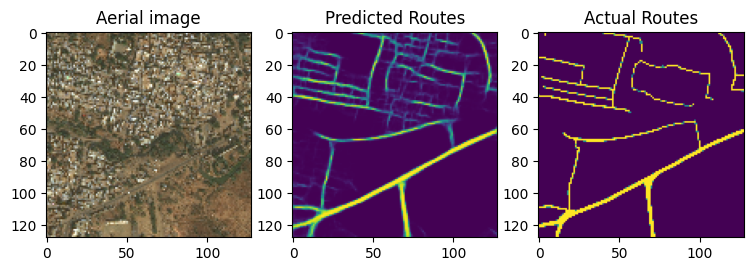

In [14]:
Plotter(actuals[2], sixteenPrediction[2][:,:,0], masks[2])

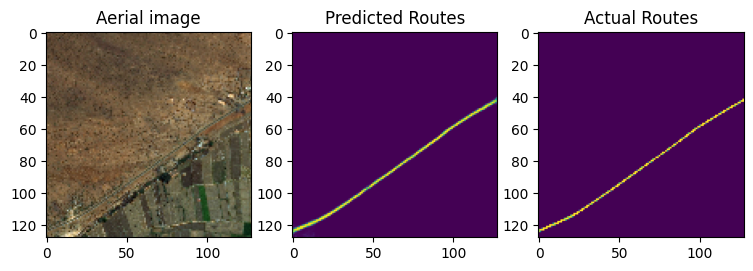

In [15]:
Plotter(actuals[10], sixteenPrediction[10][:,:,0], masks[10])

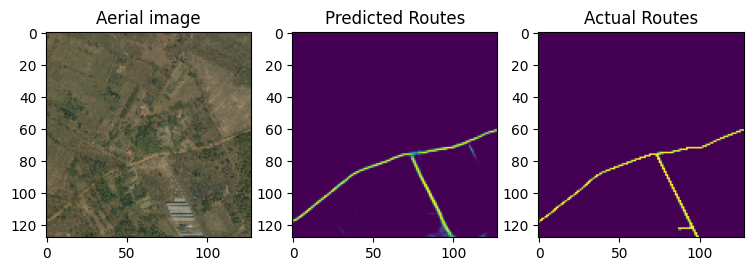

In [16]:
Plotter(actuals[13], sixteenPrediction[13][:,:,0], masks[13])

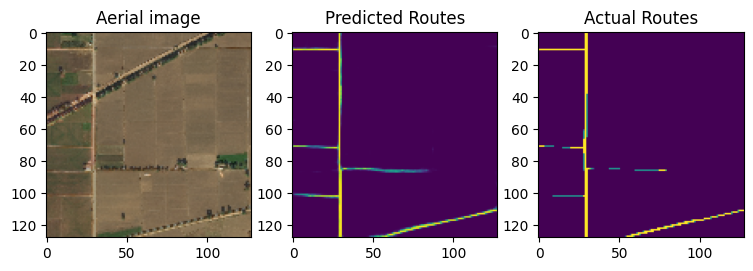

In [17]:
Plotter(actuals[5], sixteenPrediction[5][:,:,0], masks[5])

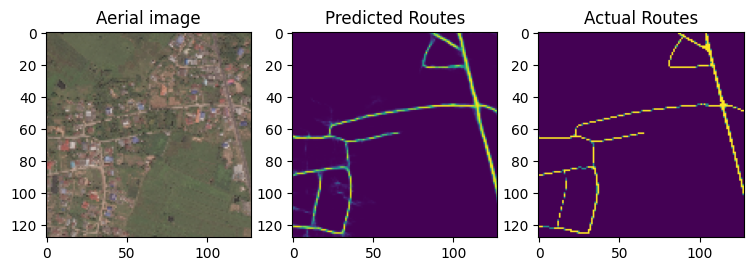

In [18]:
Plotter(actuals[15], sixteenPrediction[15][:,:,0], masks[15])

In [19]:
unet.save('MapSegmentationGenerator.keras')

In [20]:
from tensorflow.keras.models import load_model
model = load_model('MapSegmentationGenerator.keras', compile=False)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
import numpy as np
from PIL import Image

def predict_images(model, image_paths):
    """
    Predicts the output of the given model for a list of input images.

    Args:
        model: The model used for prediction.
        image_paths: A list of file paths to the input images.

    Returns:
        A list of predictions for each input image.
    """
    predictions = []
    for path in image_paths:
        image = np.array(Image.open(path).resize((128, 128)))
        prediction = model.predict(np.expand_dims(image, axis=0))
        predictions.append(prediction)
    return predictions

# Usage example
image_paths = [
    'data/test/100393_sat.jpg',
    'data/test/206133_sat.jpg',
    'data/test/314381_sat.jpg',
    'data/test/429332_sat.jpg'
]
predictions = predict_images(model, image_paths)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [22]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def visualize_results(predicted_mask, original_image, save_path=None):
    """
    Visualizes the predicted mask and the original image side by side.

    Args:
        predicted_mask (numpy.ndarray): The predicted mask.
        original_image (numpy.ndarray): The original image.
        save_path (str, optional): The file path to save the visualization. If not provided, the visualization will be displayed.

    Returns:
        None
    """
    # Convert to NumPy arrays and ensure numeric data types
    original_image = np.array(original_image).astype(np.uint8)
    predicted_mask = np.array(predicted_mask).astype(np.float32)
 
    # Display the original image
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(predicted_mask), vmin=0, vmax=1)
    plt.title('Predicted Mask')
    plt.axis('off')

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

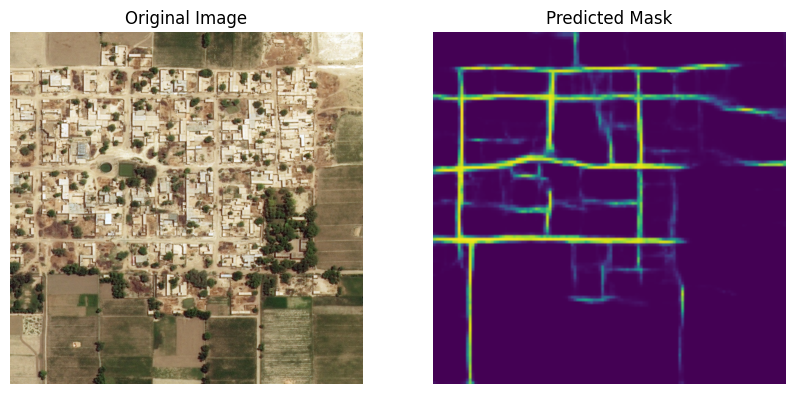

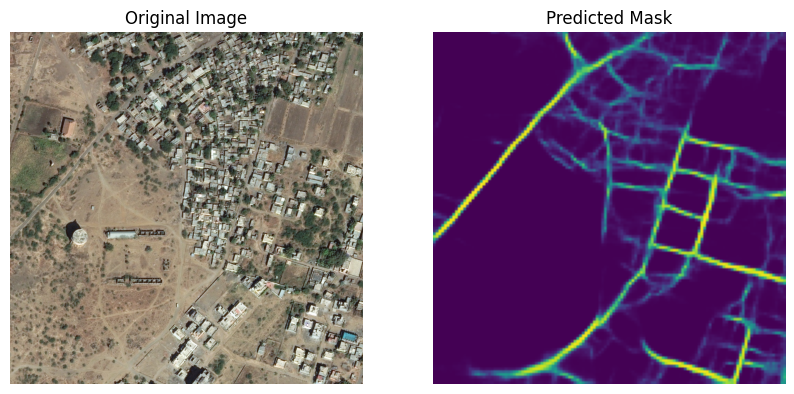

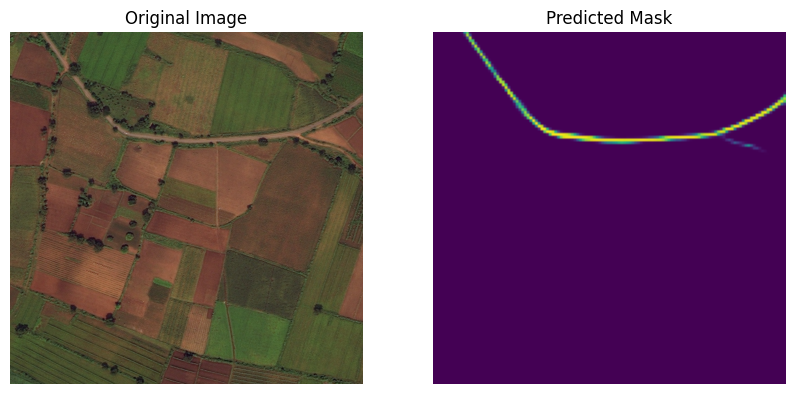

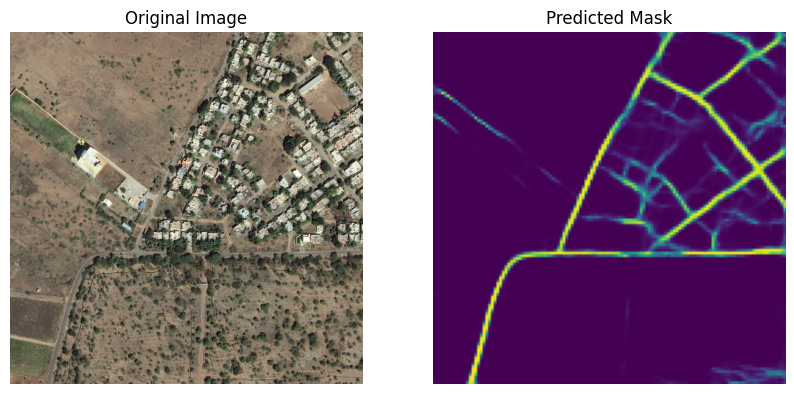

In [23]:
im1 = Image.open('data/test/100393_sat.jpg')
im2 = Image.open('data/test/206133_sat.jpg')
im3 = Image.open('data/test/314381_sat.jpg')
im4 = Image.open('data/test/429332_sat.jpg')
visualize_results(predictions[0], im1)
visualize_results(predictions[1], im2)
visualize_results(predictions[2], im3)
visualize_results(predictions[3], im4)